# Image Object Detection Model for Random Sample Images Using TensorFlow Take 4
### David Lowe
### November 4, 2021

Template Credit: Adapted from an Object Detection tutorial on TensorFlow.org.

Additional Notes: I adapted this workflow from the TensorFlow Object Detection tutorial on TensorFlow.org (https://www.tensorflow.org/hub/tutorials/object_detection). I plan to build a script for building future projects using object detection models.

SUMMARY: This project aims to construct an object detection model using the TensorFlow-based neural network and document the end-to-end steps using a template.

This iteration will use the TF2 EfficientDet D4 1024x1024 object detection model to test some sample images. The model was constructed using the EfficientDet Object detection model (SSD with EfficientNet-b4 + BiFPN feature extractor, shared box predictor, and focal loss) and trained on COCO 2017 dataset with training images scaled to 1024x1024.

Original Script Location: https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_object_detection.ipynb

Images Used: See project code below

Dataset ML Model: Image Object Detection using TensorFlow Hub Models

Additional References: https://tfhub.dev/s?module-type=image-object-detection

## Task 1 - Prepare Environment


In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Oct 29 23:19:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    45W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


In [5]:
import os
import pathlib
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

# Print Tensorflow version
print(tf.__version__)
tf.get_logger().setLevel('ERROR')

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.6.0
The following GPU devices are available: /device:GPU:0


In [6]:
# Begin the timer for the script processing
start_time_script = datetime.now()

In [7]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [8]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .


Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1675727 sha256=8aaa3ea49a342c00eebe0bc958b6b20a48f1440882aaf891494f297a506a6aff
  Stored in directory: /tmp/pip-ephem-wheel-cache-kk8smh7j/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1




  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [9]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

## Task 2 - Set up Visualization and Helper Functions

In [10]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [11]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
        path: the file path to the image

    Returns:
        uint8 numpy array with shape (img_height, img_width, 3)
    """
    image = None
    if(path.startswith('http')):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
    else:
        image_data = tf.io.gfile.GFile(path, 'rb').read()
        image = Image.open(BytesIO(image_data))

    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (1, im_height, im_width, 3)).astype(np.uint8)

In [12]:
def preprocess_original_image(selected_image, flip_image_horizontally=False,
                              convert_image_to_grayscale=False):
    # selected_image = 'Naxos Taverna'
    # flip_image_horizontally = False
    # convert_image_to_grayscale = False

    image_path = IMAGES_FOR_TEST[selected_image]
    image_np = load_image_into_numpy_array(image_path)

    # Flip horizontally
    if(flip_image_horizontally):
        image_np[0] = np.fliplr(image_np[0]).copy()

    # Convert image to grayscale
    if(convert_image_to_grayscale):
        image_np[0] = np.tile(np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    plt.figure(figsize=(24,32))
    plt.imshow(image_np[0])
    plt.show()

    return(image_np)

In [13]:
def run_detector(image_np):
    # running inference
    results = hub_model(image_np)

    # different object detection models have additional results
    # all of them are explained in the documentation
    result = {key:value.numpy() for key,value in results.items()}
    print(result.keys())

    return result

In [14]:
def process_detection_result(image_np, result):
    label_id_offset = 0
    image_np_with_detections = image_np.copy()

    # Use keypoints if available in detections
    keypoints, keypoint_scores = None, None
    if 'detection_keypoints' in result:
        keypoints = result['detection_keypoints'][0]
        keypoint_scores = result['detection_keypoint_scores'][0]

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections[0],
        result['detection_boxes'][0],
        (result['detection_classes'][0] + label_id_offset).astype(int),
        result['detection_scores'][0],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.30,
        agnostic_mode=False,
        keypoints=keypoints,
        keypoint_scores=keypoint_scores,
        keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

    plt.figure(figsize=(24,32))
    plt.imshow(image_np_with_detections[0])
    plt.show()

In [15]:
def process_model_with_masks(image_np, result):
    # Handle models with masks
    label_id_offset = 0
    image_np_with_mask = image_np.copy()

    if 'detection_masks' in result:
        # we need to convert np.arrays to tensors
        detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
        detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

        # Reframe the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes,
                    image_np.shape[1], image_np.shape[2])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                            tf.uint8)
        result['detection_masks_reframed'] = detection_masks_reframed.numpy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_mask[0],
        result['detection_boxes'][0],
        (result['detection_classes'][0] + label_id_offset).astype(int),
        result['detection_scores'][0],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.30,
        agnostic_mode=False,
        instance_masks=result.get('detection_masks_reframed', None),
        line_thickness=8)

    plt.figure(figsize=(24,32))
    plt.imshow(image_np_with_mask[0])
    plt.show()

## Task 3 - Prepare and Load Model

In [16]:
ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

In [17]:
COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1), (0, 2), (1, 3), (2, 4), (0, 5),
                               (0, 6), (5, 7), (7, 9), (6, 8), (8, 10),
                               (5, 6), (5, 11), (6, 12), (11, 12),
                               (11, 13), (13, 15), (12, 14), (14, 16)]

In [18]:
model_display_name = 'EfficientDet D4 1024x1024'
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:EfficientDet D4 1024x1024
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/efficientdet/d4/1


In [19]:
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...


model loaded!


## Task 4 - Load Images and Apply Model

In [20]:
IMAGES_FOR_TEST = {
    # Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
    'Tavern' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/60/Naxos_Taverna.jpg/1280px-Naxos_Taverna.jpg',
    # Source: https://commons.wikimedia.org/wiki/File:Floating_umbrellas_at_the_Department_store%27s_atrium_in_June_2010.jpg
    'Umbrellas' : 'https://upload.wikimedia.org/wikipedia/commons/6/67/Floating_umbrellas_at_the_Department_store%27s_atrium_in_June_2010.jpg',
    # Source: https://commons.wikimedia.org/wiki/File:Conference_Room_2.jpg
    'Conference' : 'https://upload.wikimedia.org/wikipedia/commons/7/78/Conference_Room_2.jpg',
    # Source: https://www.colchester-zoo.com/wp-content/uploads/2020/02/Lottie-1-.jpg
    'Zoo' : 'https://www.colchester-zoo.com/wp-content/uploads/2020/02/Lottie-1-.jpg',
}

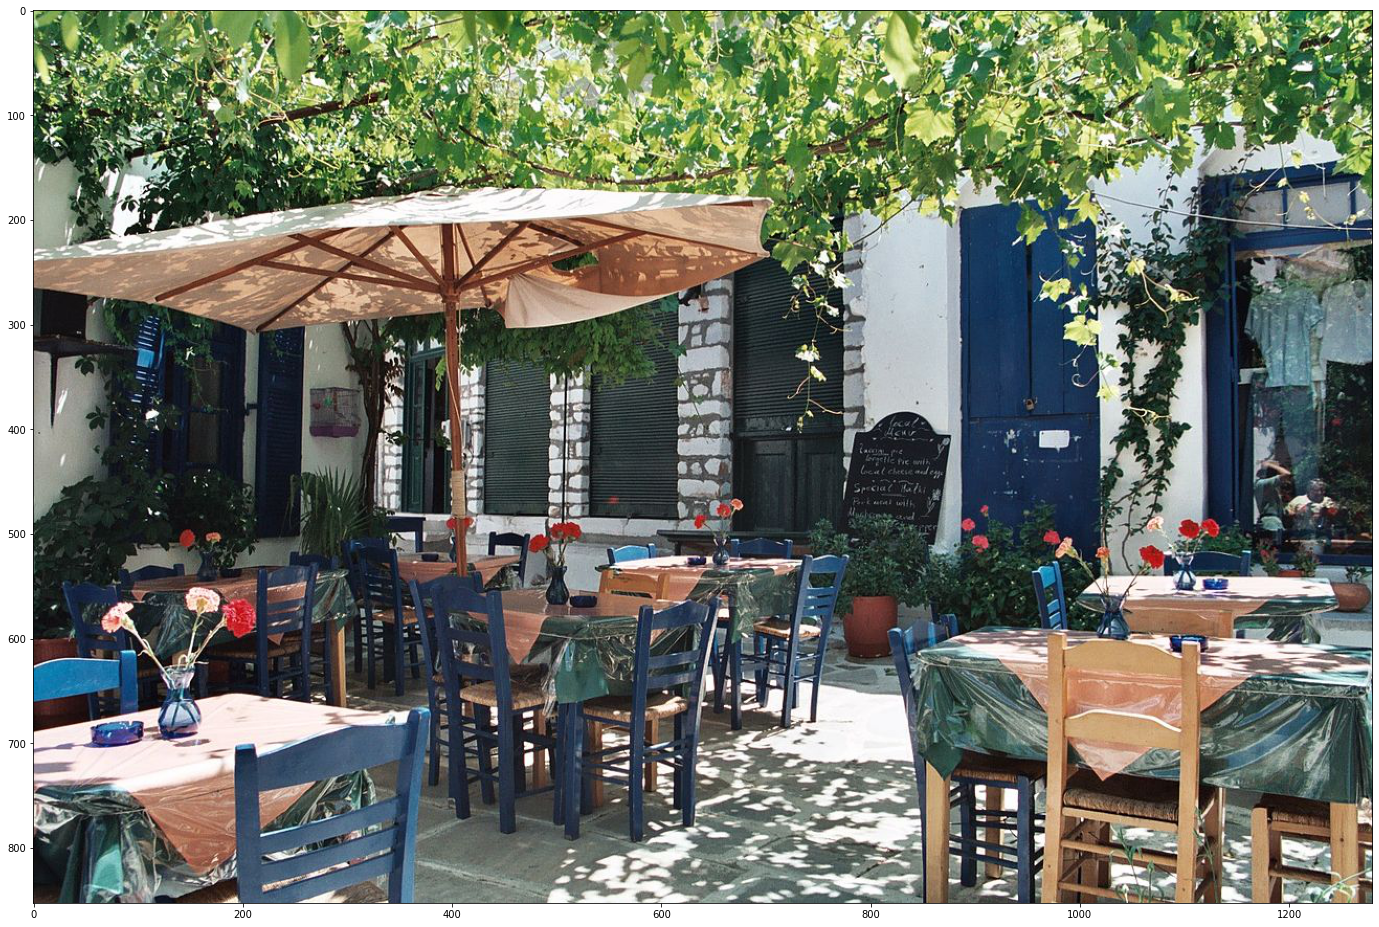

In [21]:
image_np_array = preprocess_original_image('Tavern')

In [22]:
detected_result = run_detector(image_np_array)

dict_keys(['detection_classes', 'detection_anchor_indices', 'detection_boxes', 'detection_multiclass_scores', 'raw_detection_boxes', 'raw_detection_scores', 'num_detections', 'detection_scores'])


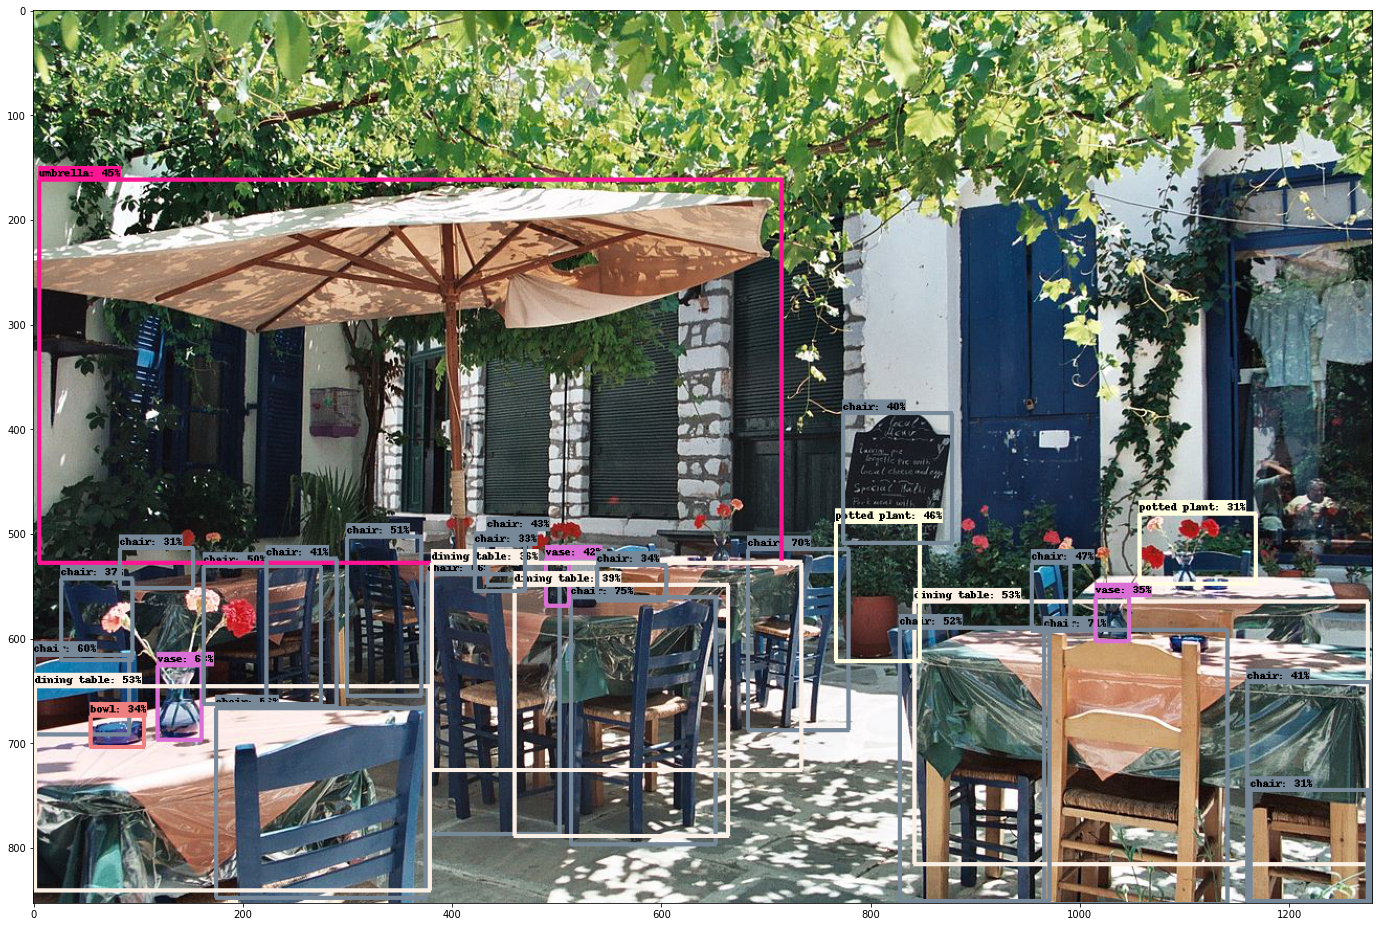

In [23]:
process_detection_result(image_np_array, detected_result)

In [24]:
# process_model_with_masks(image_np_array, detected_result)

In [25]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:01:17.503443
